In [7]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocess import Pool

from cell_utilities import *

In [2]:
dataset_name = 'largest30p'

In [3]:
PROCESSED_CELLS_DIR = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/processed_cells')

In [4]:
DETECTED_CELLS_DIR = '/home/yuncong/csd395/CSHL_cells_v2/detected_cells/' + 'MD589'

In [5]:
embeddings = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/embeddings_%(dataset_name)s_nystromSample100.bp' % \
                                    {'dataset_name': dataset_name})

# K-Means over embedding

In [9]:
# KMeans to embedding features - equiv. to spectral clustering

kmeanspp_seeds = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/%(dataset_name)s_kmeansppCenters.bp' % \
                    {'dataset_name': dataset_name})

kmeanspp_closest_seed = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/%(dataset_name)s_closestKmeansppCenters.bp' % \
                    {'dataset_name': dataset_name})

t = time.time()
class_label, centroids = kmeans(embeddings, seed_indices=kmeanspp_seeds)
sys.stderr.write('%d seconds' % (time.time() - t))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
298 seconds

In [10]:
bp.pack_ndarray_file(class_label, PROCESSED_CELLS_DIR + '/%(dataset_name)s_kmeansClassLabel.bp' % \
                     {'dataset_name': dataset_name})

In [11]:
print 'After kmeans,', len(np.where(class_label == kmeanspp_closest_seed)[0]), 'out of', len(class_label), \
'samples belong to the same centroid as at kmeans++ initialization.'

After kmeans, 13558 out of 51900 samples belong to the same centroid as at kmeans++ initialization.


In [12]:
# Load spectral clustering result

class_label = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/%(dataset_name)s_kmeansClassLabel.bp' % \
                     {'dataset_name': dataset_name})

n_class = len(np.unique(class_label))
print '%d classes\n' % n_class

100 classes



In [13]:
embedding_centroids = np.array([embeddings[class_label == cls].mean(axis=0) for cls in range(n_class)])

In [14]:
# Find group representatives 
# (medoids = the sample closest to centroid in terms of Euclidean distance in embedding space)

group_repr_indices = np.zeros((n_class,), np.int)

for cls in range(n_class):
    dists = parallel_cdist([embedding_centroids[cls]], embeddings[class_label == cls])[0]
    idx = dists.argmin()
    in_group_indices = np.where(class_label == cls)[0]
    group_repr_idx = in_group_indices[idx]
    group_repr_indices[cls] = group_repr_idx

In [15]:
# Load blob masks

selected_cell_indices = bp.unpack_ndarray_file(os.path.join(PROCESSED_CELLS_DIR, \
                                        '%(dataset_name)s_indices.bp' % {'dataset_name': dataset_name}))
n_selected_cells = len(selected_cell_indices)
print n_selected_cells, 'selected cells'

51900 selected cells


In [16]:
cells_aligned_padded = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/cells_aligned_padded.bp')
selected_cells_aligned_padded = cells_aligned_padded[selected_cell_indices].copy()
del cells_aligned_padded

In [17]:
cells_h_aligned_padded = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/cells_h_aligned_padded.bp')
selected_cells_h_aligned_padded = cells_h_aligned_padded[selected_cell_indices].copy()
del cells_h_aligned_padded

In [18]:
cells_v_aligned_padded = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/cells_v_aligned_padded.bp')
selected_cells_v_aligned_padded = cells_v_aligned_padded[selected_cell_indices].copy()
del cells_v_aligned_padded

In [19]:
cells_d_aligned_padded = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/cells_d_aligned_padded.bp')
selected_cells_d_aligned_padded = cells_d_aligned_padded[selected_cell_indices].copy()
del cells_d_aligned_padded

In [20]:
# Compute group centroid masks

average_masks = [selected_cells_aligned_padded[class_label == cls].mean(axis=0) for cls in range(n_class)]

In [27]:
# Flatten the masks

selected_cell_arrays = selected_cells_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_h = selected_cells_h_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_v = selected_cells_v_aligned_padded.reshape((n_selected_cells, -1))
selected_cell_arrays_d = selected_cells_d_aligned_padded.reshape((n_selected_cells, -1))

selected_cell_sizes = selected_cell_arrays.sum(axis=1)

In [28]:
# Get the templates

templates = selected_cells_aligned_padded[group_repr_indices]
templates_h = selected_cells_h_aligned_padded[group_repr_indices]
templates_v = selected_cells_v_aligned_padded[group_repr_indices]
templates_d = selected_cells_d_aligned_padded[group_repr_indices]
templates_flattened = selected_cell_arrays[group_repr_indices]
templates_flattened_h = selected_cell_arrays_h[group_repr_indices]
templates_flattened_v = selected_cell_arrays_v[group_repr_indices]
templates_flattened_d = selected_cell_arrays_d[group_repr_indices]

In [29]:
# Compute in-group affinities

recon_jacs = np.zeros((n_selected_cells,))
recon_bestmir = np.zeros((n_selected_cells,), np.int)
recon_jacs_perclass = [None for _ in range(n_class)]

for cls in range(n_class):
    
    in_group_index_selectors = class_label == cls
    
    arrays = selected_cell_arrays[in_group_index_selectors]
    sizes = selected_cell_sizes[in_group_index_selectors]
    
    templ_size = np.count_nonzero(templates_flattened[cls])
    
    jacs_o = compute_jaccard_x_vs_list_v2(arrays, templates_flattened[cls], sizes, templ_size)
    jacs_h = compute_jaccard_x_vs_list_v2(arrays, templates_flattened_h[cls], sizes, templ_size)
    jacs_v = compute_jaccard_x_vs_list_v2(arrays, templates_flattened_v[cls], sizes, templ_size)
    jacs_d = compute_jaccard_x_vs_list_v2(arrays, templates_flattened_d[cls], sizes, templ_size)
    jacs_stacked = np.c_[jacs_o, jacs_h, jacs_v, jacs_d]
    
    jacs_max = np.max(jacs_stacked, axis=1)
    jacs_amax = np.argmax(jacs_stacked, axis=1)
    
    recon_jacs[in_group_index_selectors] = jacs_max
    recon_bestmir[in_group_index_selectors] = jacs_amax
    
    recon_jacs_perclass[cls] = jacs_max

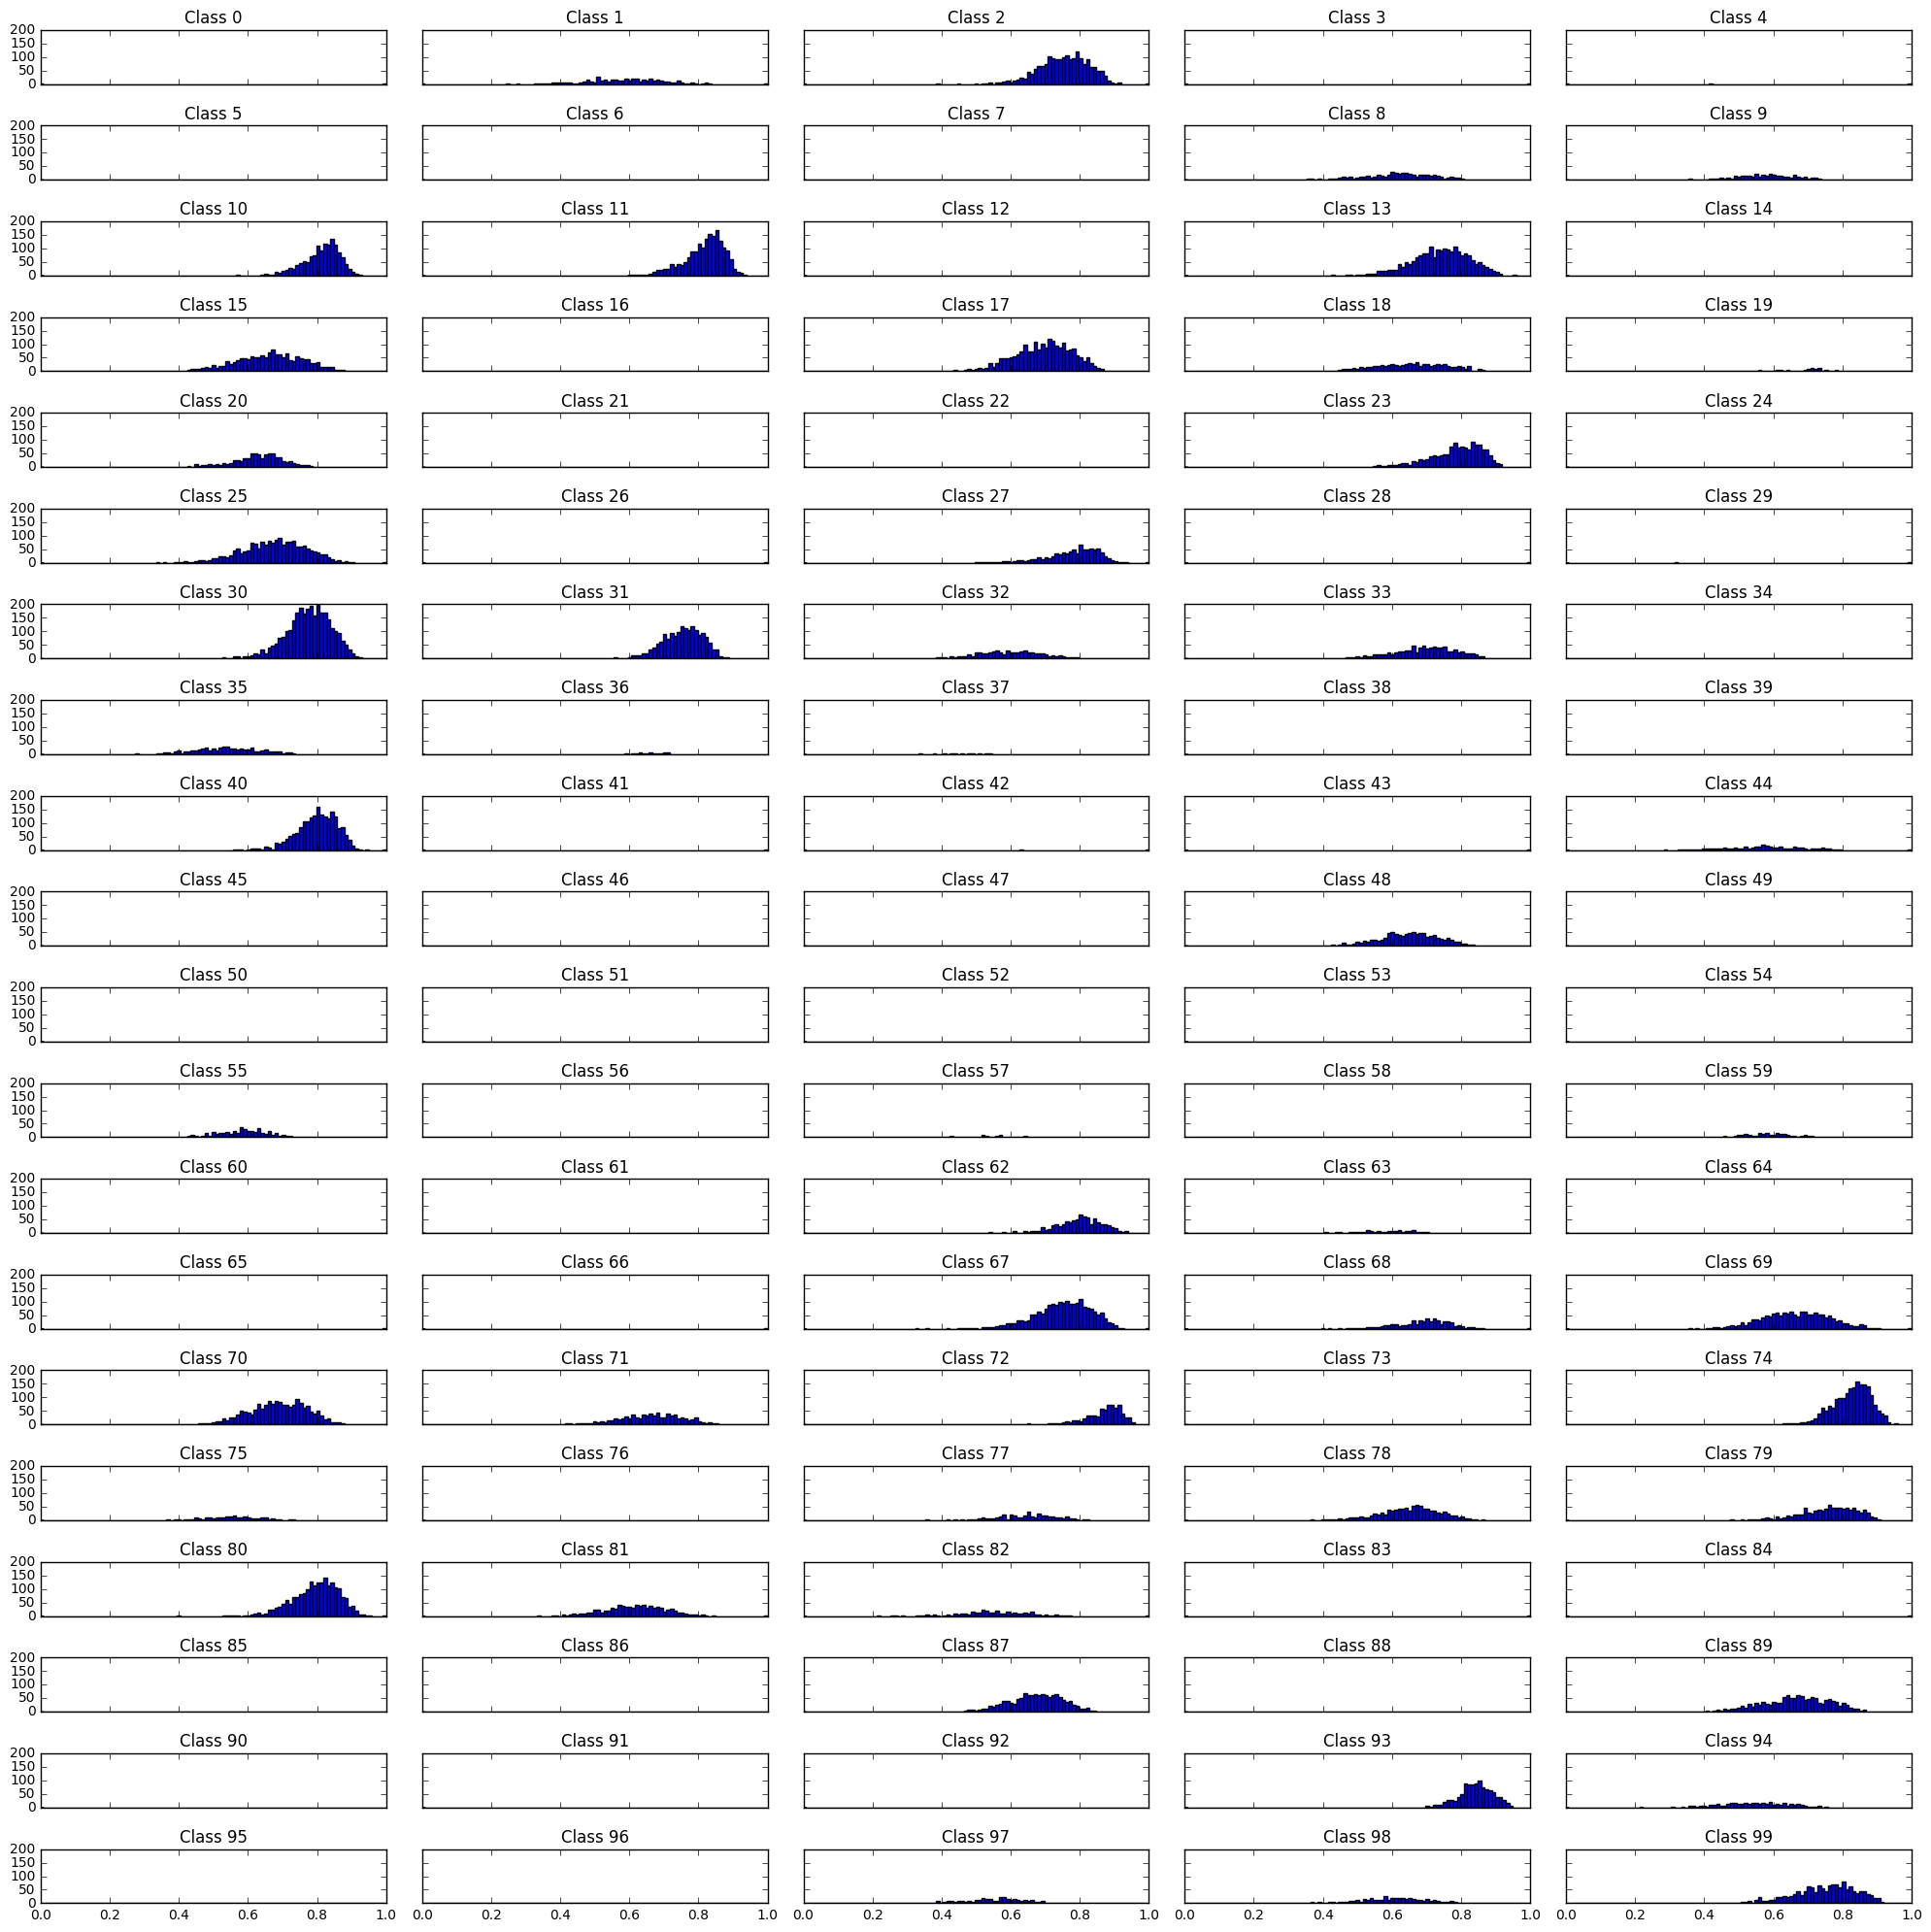

In [30]:
# Jaccard affinities within group

fig, axes = plt.subplots(nrows=20, ncols=5, sharex=True, sharey=True, figsize=(20,20))
axes = axes.flatten()
for cls, jacs in enumerate(recon_jacs_perclass):
    axes[cls].hist(jacs, bins=np.linspace(0,1,100));
    axes[cls].set_title('Class %d' % cls);
#     axes[cls].set_xlabel('Jaccard index');
#     axes[cls].set_ylabel('Number of blobs');
plt.xlabel('jaccard index');
plt.tight_layout()
plt.show()

In [31]:
# Compute average Jaccard affinities

print 'Average jaccard index against reconstruction: %.2f' % recon_jacs.mean()
for i, jacs in enumerate(recon_jacs_perclass):
    print 'Class %d: %.2f\t %d blobs' % (i, jacs.mean(), len(jacs))

Average jaccard index against reconstruction: 0.72
Class 0: 1.00	 1 blobs
Class 1: 0.59	 448 blobs
Class 2: 0.75	 1901 blobs
Class 3: 1.00	 1 blobs
Class 4: 0.71	 2 blobs
Class 5: 1.00	 1 blobs
Class 6: 1.00	 1 blobs
Class 7: 1.00	 1 blobs
Class 8: 0.62	 536 blobs
Class 9: 0.57	 377 blobs
Class 10: 0.81	 1401 blobs
Class 11: 0.82	 1841 blobs
Class 12: 1.00	 1 blobs
Class 13: 0.74	 2040 blobs
Class 14: 1.00	 1 blobs
Class 15: 0.66	 1543 blobs
Class 16: 0.62	 2 blobs
Class 17: 0.69	 2198 blobs
Class 18: 0.65	 767 blobs
Class 19: 0.65	 115 blobs
Class 20: 0.63	 782 blobs
Class 21: 1.00	 1 blobs
Class 22: 1.00	 1 blobs
Class 23: 0.79	 1405 blobs
Class 24: 1.00	 1 blobs
Class 25: 0.68	 1861 blobs
Class 26: 1.00	 1 blobs
Class 27: 0.78	 878 blobs
Class 28: 1.00	 1 blobs
Class 29: 0.66	 2 blobs
Class 30: 0.77	 3032 blobs
Class 31: 0.75	 1685 blobs
Class 32: 0.60	 624 blobs
Class 33: 0.70	 931 blobs
Class 34: 0.56	 4 blobs
Class 35: 0.54	 563 blobs
Class 36: 0.67	 60 blobs
Class 37: 0.47	 40 b

In [32]:
# Best mirror versions

hist, edges = np.histogram(recon_bestmir, bins=[0,1,2,3,4]);
print dict(zip(['orig', 'horiz', 'vert', 'diag'], hist))

{'diag': 5804, 'horiz': 11492, 'vert': 10258, 'orig': 24346}


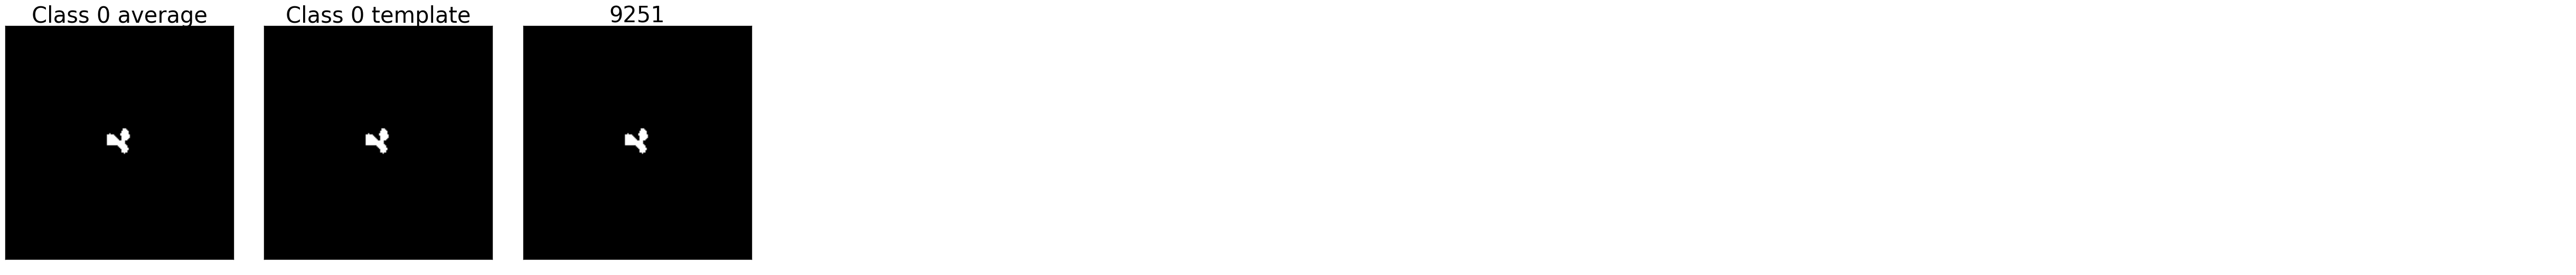

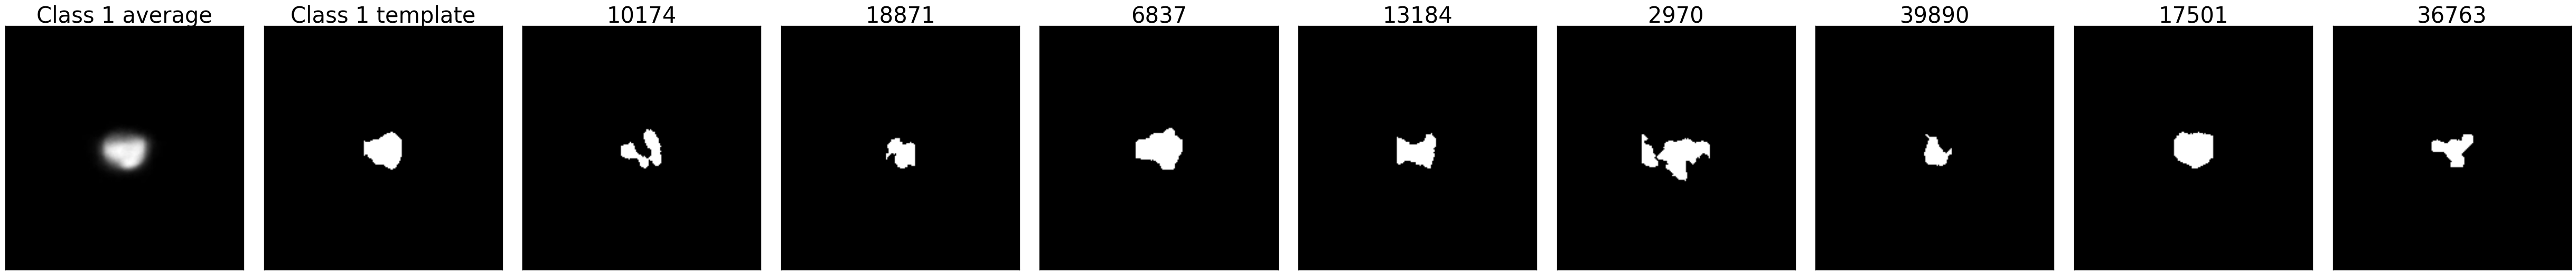

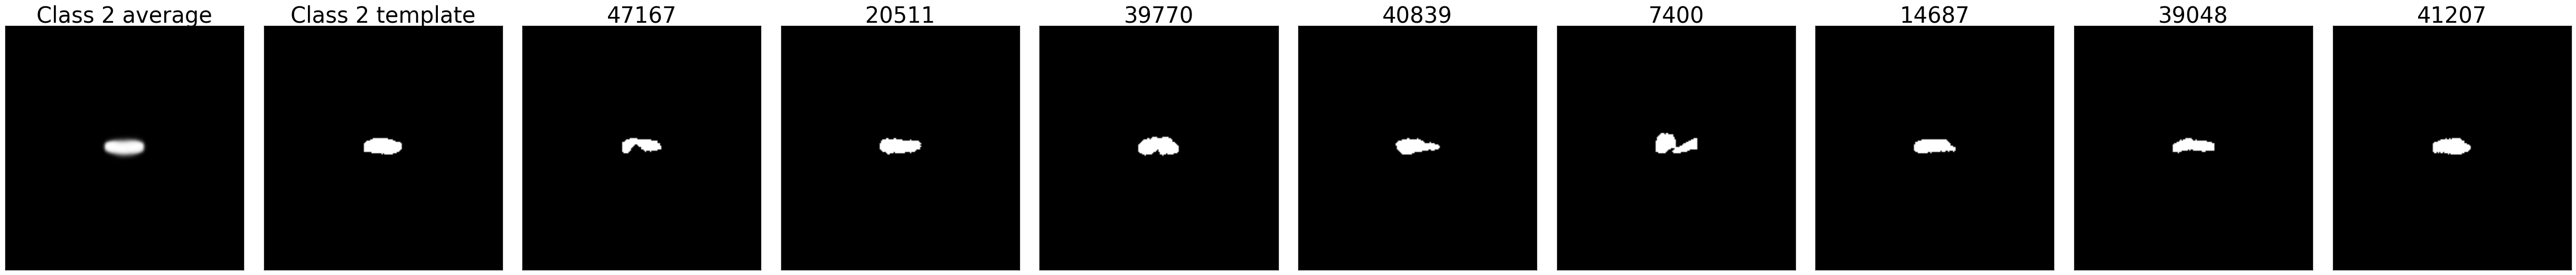

In [33]:
for cls in range(n_class)[:3]:
    
    indices = np.where(class_label == cls)[0]
    sample_indices = np.random.choice(indices, min(len(indices), 8), replace=False)            

    sample_cell_masks = []
    for i in sample_indices:
        if recon_bestmir[i] == 0:
            mask = selected_cells_aligned_padded[i]
        elif recon_bestmir[i] == 1:
            mask = selected_cells_h_aligned_padded[i]
        elif recon_bestmir[i] == 2:
            mask = selected_cells_v_aligned_padded[i]
        elif recon_bestmir[i] == 3:
            mask = selected_cells_d_aligned_padded[i]
        sample_cell_masks.append(mask)
        
    titles = ['Class %d average' % cls, 'Class %d template' % cls]
    for i in sample_indices:
        titles.append(str(i))
        
    display_images_in_grids([average_masks[cls], templates[cls]] + sample_cell_masks, 
                            nc=10, titles=titles)

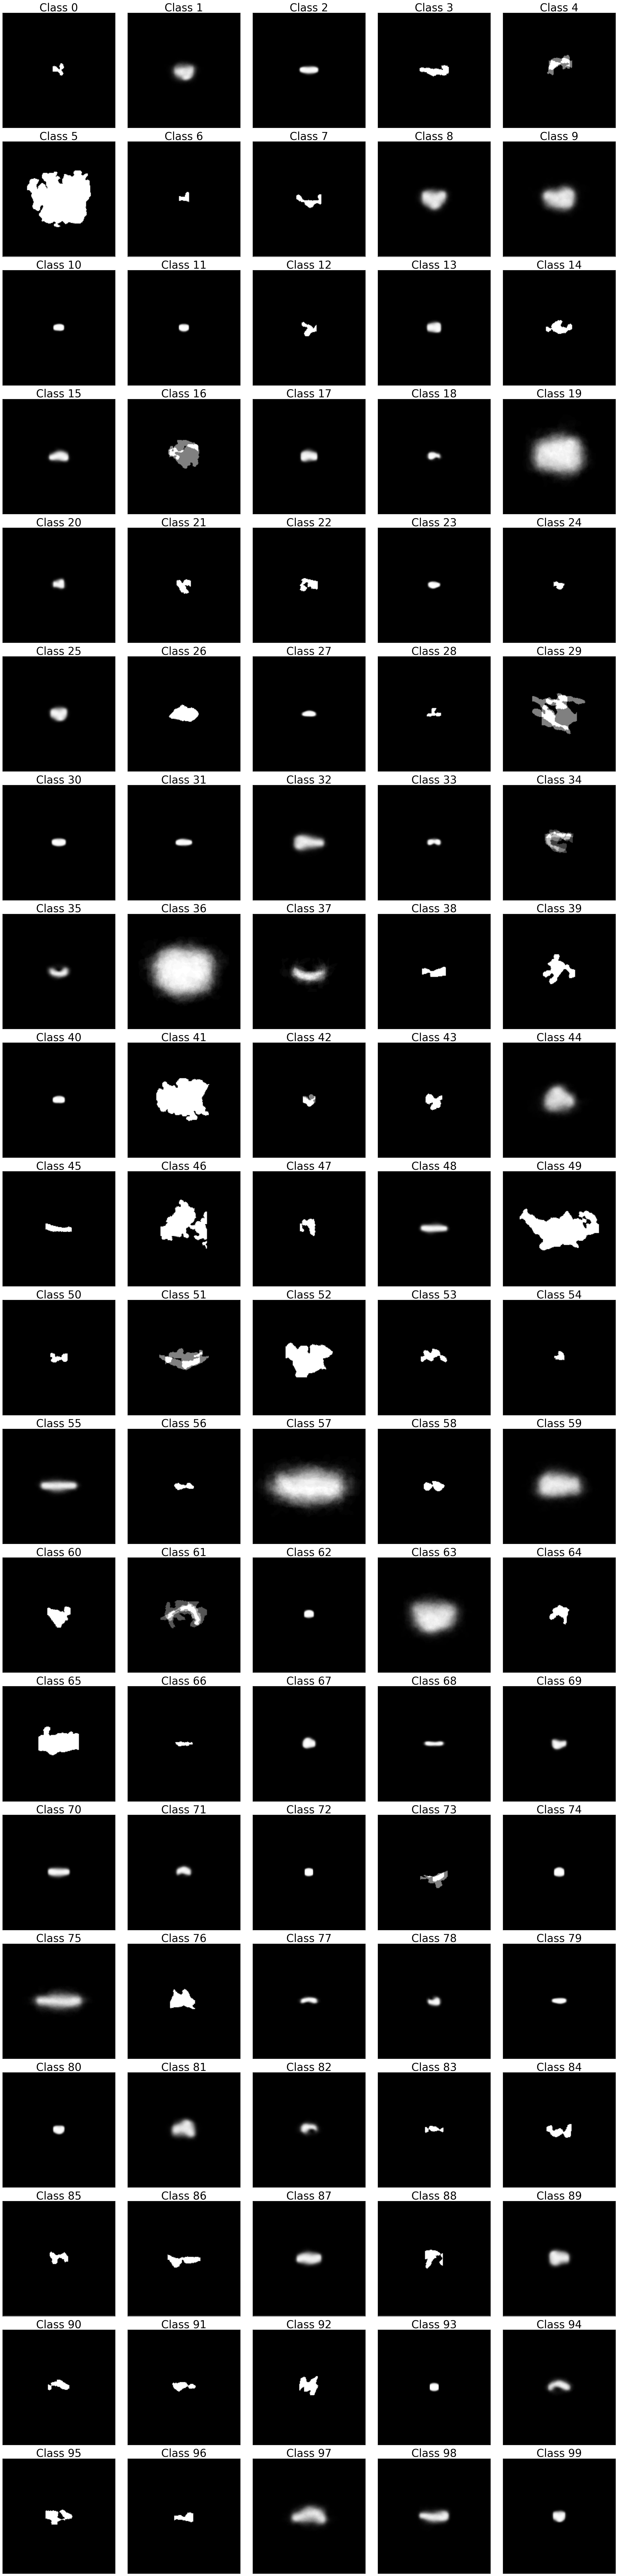

In [34]:
# Display average masks for each cluster

display_images_in_grids(average_masks, nc=5, vmin=0, vmax=1, cmap=plt.cm.gray,
                        titles=['Class %d' % cls for cls in range(n_class)])

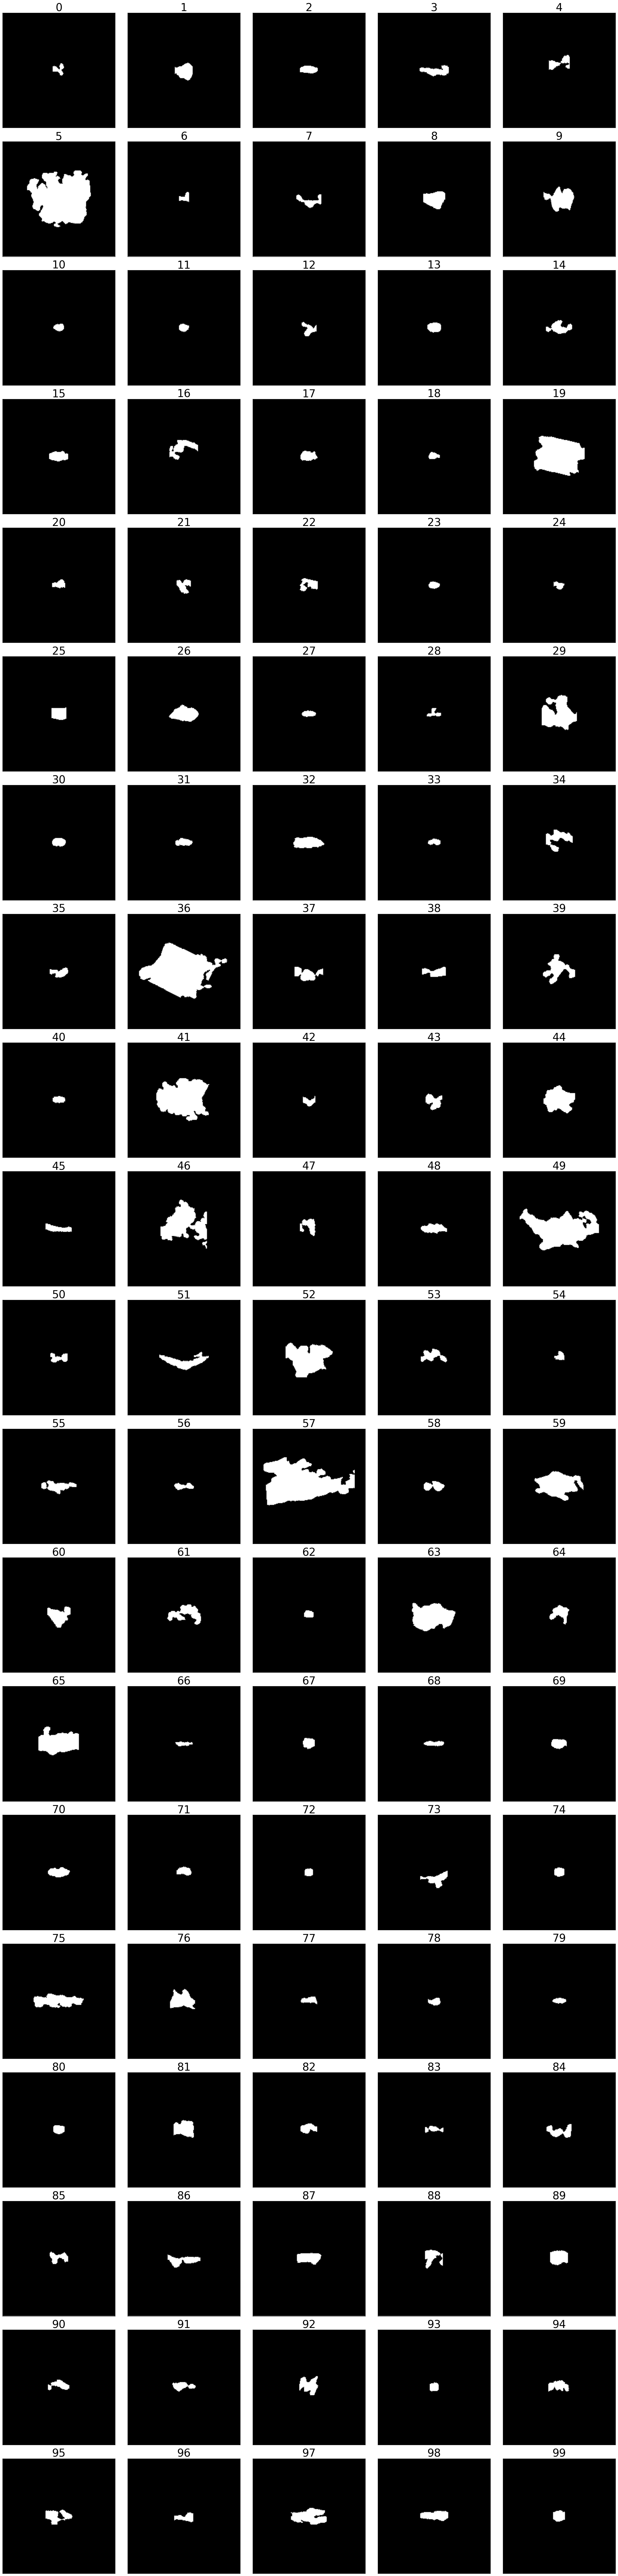

In [35]:
# Display template masks of each cluster

display_images_in_grids(templates, nc=5, titles=[str(cls) for cls in range(n_class)],
                       vmin=0, vmax=1, cmap=plt.cm.gray)

# Generate Reconstruction Image

In [36]:
cell_addresses = bp.unpack_ndarray_file(PROCESSED_CELLS_DIR + '/cell_addresses.bp')

n_cells = len(cell_addresses)
print n_cells, 'cells'

selected_cell_addresses = [cell_addresses[i] for i in selected_cell_indices]

172998 cells


In [37]:
sections_to_filenames = metadata_cache['sections_to_filenames']['MD589']
first_bs_section, last_bs_section = metadata_cache['section_limits']['MD589']

In [38]:
cell_centers = {}
cell_orientations = {}
cell_majorAxisLens = {}
cell_minorAxisLens = {}
cell_maskCenters = {}

# for sec in range(first_bs_section, last_bs_section, 50):
for sec in [192, 242]:
    fn = sections_to_filenames[sec]
    cell_orientations[sec] = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobOrientations.bp' % {'fn': fn})
    cell_majorAxisLens[sec] = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobMajorAxisLen.bp' % {'fn': fn})
    cell_minorAxisLens[sec] = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobMinorAxisLen.bp' % {'fn': fn})
    cell_maskCenters[sec] = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobMaskCenters.bp' % {'fn': fn})
    cell_centers[sec] = bp.unpack_ndarray_file(DETECTED_CELLS_DIR + '/%(fn)s/%(fn)s_blobCentroids.bp' % {'fn': fn})

In [39]:
LARGE = 2
ELLIPSE = 0

In [40]:
# All cells default to ELLIPSE
cell_categories = ELLIPSE * np.ones((n_cells,), np.int)

# except those in dataset_cell_indices are set to LARGE
cell_categories[selected_cell_indices] = LARGE

In [41]:
overall_idx_to_selected_idx = {idx: i for i, idx in enumerate(selected_cell_indices)}

In [42]:
def gen_descriptor_work(i):
    
    sec, idx = cell_addresses[i]
    
    center = cell_centers[sec][idx]
    major_len = cell_majorAxisLens[sec][idx]
    minor_len = cell_minorAxisLens[sec][idx]
    orient = cell_orientations[sec][idx]
    
    if cell_categories[i] == ELLIPSE:
        descriptor = (center, orient, major_len, minor_len)
    elif cell_categories[i] == LARGE:
#         return None
#         index_in_all_data = list(dataset_cell_indices).index(i)
        oi = overall_idx_to_selected_idx[i]
        embedding_feature = embeddings[oi]
        template_idx = class_label[oi]
        descriptor = (center, orient, embedding_feature, template_idx)
    else:
        sys.stderr.write('cell category invalid.\n')
        return None
    
    return descriptor

In [43]:
# Generate descriptors for blobs

t = time.time()

pool = Pool(12)
descriptors = pool.map(gen_descriptor_work, range(n_cells))
pool.terminate()
pool.join()

sys.stderr.write('time: %s' % (time.time() - t)) # 168s

time: 35.3152310848

In [90]:
# # USE the parallel version above instead

# descriptors = []

# bar = show_progress_bar(0, n_cells-1)

# for i in range(n_cells):
    
#     bar.value = i
    
#     sec, idx = cell_addresses[i]
    
#     center = cell_centers[sec][idx]
#     major_len = cell_majorAxisLens[sec][idx]
#     minor_len = cell_minorAxisLens[sec][idx]
#     orient = cell_orientations[sec][idx]
    
#     if cell_categories[i] == ELLIPSE:
#         descriptors.append((center, orient, major_len, minor_len))
#     elif cell_categories[i] == LARGE:
        
#         index_in_all_data = list(dataset_cell_indices).index(i)
        
#         embedding_feature = embeddings[index_in_all_data]
#         template_idx = class_label[index_in_all_data]
        
#         descriptors.append((center, orient, embedding_feature, template_idx))

In [44]:
stack = 'MD589'

In [45]:
image_w, image_h = metadata_cache['image_shape'][stack]

In [46]:
recon_image_dir = create_if_not_exists('/home/yuncong/csd395/CSHL_cells_v2/reconstructed_images/%(stack)s' %{'stack':stack})

In [47]:
from skimage.draw import ellipse_perimeter
from skimage.transform import rotate

In [48]:
address_to_overall_idx = {tuple(addr): i for i, addr in enumerate(cell_addresses.tolist())}

In [51]:
template_centers = [np.mean(np.where(templates[cls]), axis=1)[::-1] for cls in range(n_class)]

In [52]:
class_colors = np.random.randint(0, 255, (n_class, 3))

In [53]:
# for sec in range(first_bs_section, last_bs_section, 50):
for sec in [192, 242]:
    
#     contour_pixels = []
    
    reconstructed_image = np.zeros((image_h, image_w, 4), np.uint8)
    
    n = cell_centers[sec].shape[0]
    print n, 'blobs'
    
#     n2 = 1000
#     n2 = n
    
#     bar = show_progress_bar(0, n2)
    bar = show_progress_bar(0, n)

#     for i, idx in enumerate(np.random.choice(range(n), n2, replace=False)):
    for idx in range(n):
#         i = idx
        
        bar.value = idx
        
        index_in_all_data = address_to_overall_idx[(sec, idx)]
        
        if cell_categories[index_in_all_data] == LARGE:
            
            center, orient, embedding_feature, template_idx = descriptors[index_in_all_data]
            
            template = templates[template_idx]
            template_c = template_centers[template_idx]
            
            template_rotated = rotate(template, angle=np.rad2deg(orient), 
                                      center=template_c, cval=0.) > .5
            
            ys, xs = np.where(template_rotated)
            
            cell_c = cell_centers[sec][idx]
            
            xs = np.minimum(image_w-1, xs - template_c[0] + cell_c[0]).astype(np.int)
            ys = np.minimum(image_h-1, ys - template_c[1] + cell_c[1]).astype(np.int)
            
            color = class_colors[template_idx]
            
#             reconstructed_image[ys, xs] = (255, 255, 255, 255)
            reconstructed_image[ys, xs] = (color[0], color[1], color[2], 255)
    
        elif cell_categories[index_in_all_data] == ELLIPSE:
            
            center, orient, major_len, minor_len = descriptors[index_in_all_data]
            
            cv2.ellipse(reconstructed_image, tuple(center.astype(np.int)), 
                        (int(major_len/2), int(minor_len/2)), 
                        -np.rad2deg(orient), 0, 360, (0, 255, 0, 255), -1)
                        
#             yy, xx = ellipse_perimeter(int(cell_centers[sec][idx][1]), 
#                               int(cell_centers[sec][idx][0]), 
#                               int(cell_minorAxisLens[sec][idx]/2), 
#                               int(cell_majorAxisLens[sec][idx]/2), 
#                               orientation=-np.rad2deg(cell_orientations[sec][idx]),
#                              shape=(image_h, image_w))
#             contour_pixels.append(np.c_[xx, yy])
            
#         elif i in dataset_cell_indices['spherical']:
            
#             cv2.circle(reconstructed_image, tuple(cell_centers[sec][i][::-1].astype(np.int)), 
#                        int(cell_majorAxisLens[sec][i]/2), (255, 255, 255), -1)
            
    fn = sections_to_filenames[sec]
    imsave(os.path.join(recon_image_dir, '%(fn)s_reconstructedImage.png' % {'stack':stack, 'fn': fn}), 
           reconstructed_image)

92351 blobs
80647 blobs


In [75]:
display_image(reconstructed_image)

/oasis/projects/nsf/csd395/yuncong/Brain/cells/tmp.jpg